<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#." data-toc-modified-id=".-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>.</a></span></li><li><span><a href="#." data-toc-modified-id=".-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>.</a></span></li><li><span><a href="#Download-+-Preprocess-Data" data-toc-modified-id="Download-+-Preprocess-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Download + Preprocess Data</a></span><ul class="toc-item"><li><span><a href="#Download" data-toc-modified-id="Download-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Download</a></span></li><li><span><a href="#Preprocess" data-toc-modified-id="Preprocess-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Preprocess</a></span></li></ul></li><li><span><a href="#Models" data-toc-modified-id="Models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Models</a></span><ul class="toc-item"><li><span><a href="#~Inception-v4" data-toc-modified-id="~Inception-v4-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>~Inception v4</a></span></li><li><span><a href="#VGG" data-toc-modified-id="VGG-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>VGG</a></span></li></ul></li><li><span><a href="#Model-Comparison" data-toc-modified-id="Model-Comparison-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Comparison</a></span></li></ul></div>

From [this class][class] (look at more of their notes later)

Design principles
* Reduce filter sizes (except possibly at the lowest layer), factorize filters aggressively
* Use 1x1 convolutions to reduce and expand the number of feature maps judiciously
* Use skip connections and/or create multiple paths through the network 

What else?
* Training tricks and details: initialization, regularization, normalization
* Training data augmentation
* Averaging classifier outputs over multiple crops/flips
    * At test time, predict on original img, LR-flipped image, and a couple of (resized) crops of the image. Combine the predictions (either the mode or else average the probabilities and then the max prob)
* Ensembles of networks

[class]: http://slazebni.cs.illinois.edu/spring17/

Submit results [here][submission] with team code: **KknPS9LrSKwM2cFXe9T2**

See the leaderboard [here][lb].

[submission]: http://miniplaces.csail.mit.edu/submit.php
[lb]: http://miniplaces.csail.mit.edu/leaderboard.php

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tnrange
import time
import os
import sys
from computer_vision.scripts.utils import tf_init, get_next_run_num, load_data, output_file
from computer_vision.scripts.layers import ConvLayer, MaxPoolLayer, AvgPoolLayer, BranchedLayer, MergeLayer, LayerModule, FlattenLayer, DenseLayer, GlobalAvgPoolLayer, DropoutLayer, GlobalMaxPoolLayer, ResidualLayer
from computer_vision.scripts.models import CNN, CNN2, BaseNN

%matplotlib inline
config = tf_init()

# .

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
from gpu_dashboard.tf_utils import tf_init
import matplotlib.pyplot as plt

config = tf_init()
%matplotlib inline

/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [5]:
data_dir = '/scratch/nhunt/cv_nathan/miniplaces/data/'
img_dir = f'{data_dir}/images/'

label_map = pd.read_csv(f'{data_dir}/labels/categories.txt', header=None, sep=' ', names=['label_txt', 'label_id'])
label_map = label_map.set_index('label_id')
label_map.head()

,label_txt
label_id,
0,/a/abbey
1,/a/airport_terminal
2,/a/amphitheater
3,/a/amusement_park
4,/a/aquarium


In [7]:
# for test, use the label to store the index; this will let us sort the test predictions back into the right order

with open(f'{data_dir}/labels/test.txt', 'w') as f:
    for i in range(1, 10_001):
        f.write(f"test/{str(i).zfill(8)}.jpg {i}\n")

In [8]:
split = 'test'
record_fname = f'{data_dir}/{split}_0.tfrecord'

In [9]:
img_data = (pd.read_csv(f'{data_dir}/labels/{split}.txt', sep=' ', header=None, names=['img_fname', 'label_id'])
            .sample(frac=1, replace=False)  # shuffle
            .assign(img_fname=lambda df: df.img_fname.map(lambda fname: f"{img_dir}/{fname}"))
           )
img_data = img_data
img_data.head()

,img_fname,label_id
9120,/scratch/nhunt/cv_nathan/miniplaces/data//imag...,9121
6637,/scratch/nhunt/cv_nathan/miniplaces/data//imag...,6638
4574,/scratch/nhunt/cv_nathan/miniplaces/data//imag...,4575
9221,/scratch/nhunt/cv_nathan/miniplaces/data//imag...,9222
6403,/scratch/nhunt/cv_nathan/miniplaces/data//imag...,6404


In [10]:
writer = tf.python_io.TFRecordWriter(record_fname)
for i in range(len(img_data)):
    img_fname, label = img_data.iloc[i]
    with open(img_fname, 'rb') as f:
        img = f.read()

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img])),
        'image_format': tf.train.Feature(bytes_list=tf.train.BytesList(value=['jpg'.encode()])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
        'fname': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_fname.encode()]))
    }))
    
    writer.write(example.SerializeToString())
writer.close()

In [37]:
sess = tf.Session(config=config)

In [49]:
def parse_example(example_proto: bytes):
    features = {
        'image': tf.FixedLenFeature((), tf.string),
        'label': tf.FixedLenFeature((), tf.int64),
        'image_format': tf.FixedLenFeature((), tf.string, default_value='jpg')
    }
    example = tf.parse_single_example(example_proto, features)
    return tf.image.decode_jpeg(example['image']), example['label']

In [59]:
batch_size = 64

In [60]:
filenames = tf.placeholder(tf.string, shape=[None])
dataset = (tf.data.TFRecordDataset(filenames)
           .map(parse_example)
           .repeat()
           .shuffle(buffer_size=5000)
           .batch(batch_size)
          )
iterator = dataset.make_initializable_iterator()

In [61]:
training_filenames = [record_fname]
sess.run(iterator.initializer, feed_dict={filenames: training_filenames})

In [66]:
img, label = iterator.get_next()

In [72]:
img = tf.cast(tf.reshape(img, (-1, 128, 128, 3)), tf.float32)

In [73]:
tf.layers.conv2d(img, 32, 3)

<tf.Tensor 'conv2d_3/BiasAdd:0' shape=(?, 126, 126, 32) dtype=float32>

In [79]:
from models import CNN2

ImportError: cannot import name 'CNN2'

# .

In [2]:
train_inputs, train_labels, val_inputs, val_labels, test_inputs = load_data('miniplaces')
n_classes = len(np.unique(train_labels))

In [2]:
import tensorflow as tf
import tflearn
import matplotlib.pyplot as plt
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''
%matplotlib inline

/afs/csail.mit.edu/u/n/nhunt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
dtype = tf.float32
img = tf.placeholder(dtype, (None, 128, 128, 3))
img

<tf.Tensor 'Placeholder:0' shape=(?, 128, 128, 3) dtype=float32>

In [3]:
img = tf.map_fn(tf.image.random_flip_left_right, img)
img

<tf.Tensor 'map/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, 128, 128, 3) dtype=float32>

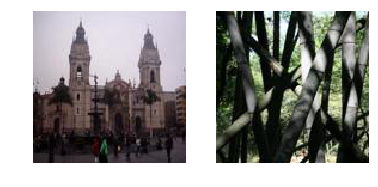

In [5]:
imgs = [plt.imread(f'/afs/csail.mit.edu/u/n/nhunt/0000000{i}.jpg') for i in range(1, 3)]

plt.subplot(121)
plt.imshow(imgs[0])
plt.axis('off')

plt.subplot(122)
plt.imshow(imgs[1])
plt.axis('off');

In [39]:
def augment_imgs(imgs: np.ndarray, rotate_angle: int=10, shear_intensity: float=.15, width_shift_frac: float=.1,
                 height_shift_frac: float=.1,width_zoom_frac: float=.85, height_zoom_frac: float=.85,
                 crop_height: int=100, crop_width: int=100) -> np.ndarray:
    keras_params = dict(row_axis=0, col_axis=1, channel_axis=2, fill_mode='reflect')

    rotate = lambda img: tf.keras.preprocessing.image.random_rotation(img, rotate_angle, **keras_params)
    shear = lambda img: tf.keras.preprocessing.image.random_shear(img, shear_intensity, **keras_params)
    # shift = lambda img: tf.keras.preprocessing.image.random_shift(img, width_shift_frac, height_shift_frac, **keras_params)
    # zoom = lambda img: tf.keras.preprocessing.image.random_zoom(img, (width_zoom_frac, height_zoom_frac), **keras_params)

    img_aug = tflearn.data_augmentation.ImageAugmentation()
    img_aug.add_random_crop((crop_height, crop_width))
    img_aug.add_random_flip_leftright()
    
    aug_imgs = np.zeros_like(imgs)
    for i in range(len(imgs)):
        aug_imgs[i] = np.random.choice([rotate, shear])(imgs[i])
    aug_imgs = img_aug.apply(aug_imgs)
    return aug_imgs

In [28]:
imgs = np.concatenate([img.reshape(1, *img.shape) for img in imgs])

In [40]:
aug_imgs = augment_imgs(imgs)

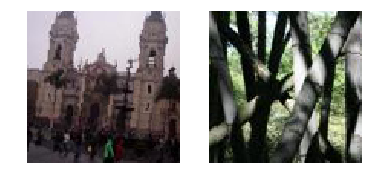

In [41]:
plt.subplot(121)
plt.imshow(aug_imgs[0])
plt.axis('off')

plt.subplot(122)
plt.imshow(aug_imgs[1])
plt.axis('off');

In [23]:
import numpy as np

In [24]:
np.random.choice([rotate, shear, shift, zoom])

<function __main__.<lambda>>

In [ ]:
tf.image.random_flip_left_right(i)

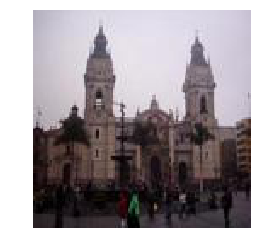

In [41]:
plt.imshow(tf.keras.preprocessing.image.random_rotation(i, 10))
plt.axis('off');

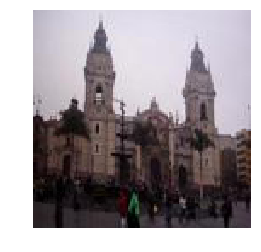

In [80]:
plt.imshow(tf.keras.preprocessing.image.random_shear(i, .15, row_axis=0, col_axis=1, channel_axis=2, fill_mode='reflect'))
plt.axis('off');

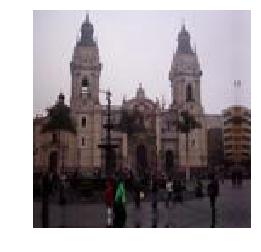

In [96]:
plt.imshow(tf.keras.preprocessing.image.random_shift(i, .1, .1, row_axis=0, col_axis=1, channel_axis=2, fill_mode='reflect'))
plt.axis('off');

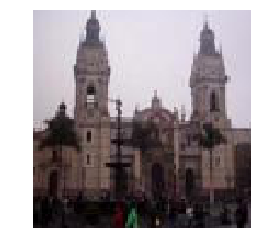

In [126]:
plt.imshow(tf.keras.preprocessing.image.random_zoom(i, (.85, .85), row_axis=0, col_axis=1, channel_axis=2, fill_mode='reflect'))
plt.axis('off');

In [5]:
sess = tf.InteractiveSession()

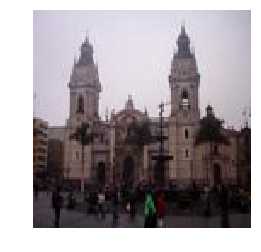

In [10]:
plt.imshow(tf.image.random_flip_left_right(i).eval())
plt.axis('off');

In [8]:
img_aug = tflearn.data_augmentation.ImageAugmentation()
img_aug.add_random_crop((100, 100))
img_aug.add_random_flip_leftright()

In [11]:
i = imgs[0]

(100, 100, 3)


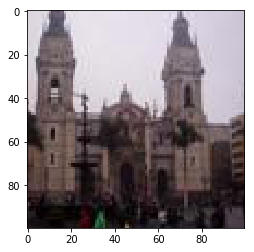

In [21]:
iz = img_aug.apply(i.reshape(1, *i.shape))[0]
print(iz.shape)
plt.imshow(iz)

In [3]:
batch_size = 128

In [5]:
layers = [
    ConvLayer(32, 3, 4, batch_norm=False),
    ConvLayer(32, 3, 4, batch_norm=False),
    FlattenLayer(),
    DropoutLayer(0.5)
]

cnn = CNN(layers, n_classes=n_classes, record=False, batch_size=batch_size)

Instructions for updating:
Use `argmax` instead


In [4]:
inception_a = LayerModule([
    BranchedLayer([AvgPoolLayer(1, 1), ConvLayer(96, 1), ConvLayer(64, 1), ConvLayer(64, 1)]),
    BranchedLayer([ConvLayer(96, 1), None, ConvLayer(96, 3), ConvLayer(96, 3)]),
    BranchedLayer([None, None, None, ConvLayer(96, 3)]),
    MergeLayer(axis=3)
])

inception_b = LayerModule([
    BranchedLayer([AvgPoolLayer(1, 1), ConvLayer(384, 1), ConvLayer(192, 1), ConvLayer(192, 1)]),
    BranchedLayer([ConvLayer(128, 1), None, ConvLayer(224, [7, 1]), ConvLayer(192, [1, 7])]),
    BranchedLayer([None, None, ConvLayer(256, [1, 7]), ConvLayer(224, [7, 1])]),
    BranchedLayer([None, None, None, ConvLayer(224, [1, 7])]),
    BranchedLayer([None, None, None, ConvLayer(256, [7, 1])]),
    MergeLayer(axis=3)
])

inception_c = LayerModule([
    BranchedLayer([AvgPoolLayer(1, 1), ConvLayer(256, 1), ConvLayer(384, 1), ConvLayer(384, 1)]),
    BranchedLayer([ConvLayer(256, 1), None, BranchedLayer([ConvLayer(256, [1, 3]), ConvLayer(256, [3, 1])]), ConvLayer(448, [1, 3])]),
    BranchedLayer([None, None, None, ConvLayer(512, [3, 1])]),
    BranchedLayer([None, None, None, BranchedLayer([ConvLayer(256, [3, 1]), ConvLayer(256, [1, 3])])]),
    MergeLayer(axis=3)
])

layers = [
    ConvLayer(32, 3, 2, padding='valid'),
    ConvLayer(32, 3),
    ConvLayer(64, 3),
    BranchedLayer([MaxPoolLayer(3, padding='valid'), ConvLayer(96, 3, padding='valid')]), # don't use stride of 2 since our images are smaller
    MergeLayer(axis=3),
    BranchedLayer([ConvLayer(64, 1), ConvLayer(64, 1)]),
    BranchedLayer([ConvLayer(96, 3, padding='valid'), ConvLayer(64, [7, 1])]),
    BranchedLayer([None, ConvLayer(64, [1, 7])]),
    BranchedLayer([None, ConvLayer(96, 3, padding='valid')]),
    MergeLayer(axis=3),
    BranchedLayer([ConvLayer(192, 3, strides=2, padding='valid'), MaxPoolLayer(3, strides=2, padding='valid')]),
    MergeLayer(axis=3),
    *([inception_a] * 1), # x4
    ConvLayer(1024, 3, strides=2), # reduction_a
    *([inception_b] * 1), # x7
    ConvLayer(1536, 3, strides=2), # reduction_b
    *([inception_c] * 1), # x3
    GlobalAvgPoolLayer(),
    FlattenLayer(),
    DropoutLayer(rate=0.8)
]

cnn = CNN(layers, n_classes=n_classes, record=False, batch_size=batch_size, config=config, l2_lambda=.001, learning_rate=.0003) # add_scaling=True

Instructions for updating:
Use `argmax` instead


In [5]:
train_idx = range(len(train_labels))
idx = np.random.choice(train_idx, size=10000)

In [6]:
cnn.train(train_inputs[idx], train_labels[idx], val_inputs, val_labels, verbose=2, n_epochs=2)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

0/|/Epoch 1. Train Loss: 5.718. Dev loss: 244.392. Runtime 0.93.:   0%|| 0/2 [00:55<?, ?epoch/s]

A Jupyter Widget

A Jupyter Widget

1/|/Epoch 2. Train Loss: 5.541. Dev loss: 174.756. Runtime 1.87.:  50%|| 1/2 [01:52<01:52, 112.41s/epoch]


{'acc_default': 0.017100001,
 'dev_loss': 174.75555,
 'train_complete': False,
 'train_loss': 5.5414991,
 'train_time': 1.8735886255900065}

In [10]:
graph = tf.Graph()
with graph.as_default():
    labels = tf.placeholder(tf.int32, shape=None)
    img = tf.placeholder(tf.float32, (None, 128, 128, 3))

    layers = [
        tf.layers.Conv2D(32, 3, 4, activation=tf.nn.relu), # image size reduces to 32 * 32
        tf.layers.Conv2D(32, 3, 4, activation=tf.nn.relu),
#         tf.layers.Conv2D(64, [1, 5], activation=tf.nn.relu),
#         tf.layers.Conv2D(64, [5, 1], activation=tf.nn.relu),
#         tf.layers.Conv2D(128, 3, 2, activation=tf.nn.relu),
#         tf.layers.Conv2D(256, 3, 2, activation=tf.nn.relu),
#         tf.layers.Conv2D(512, 3, 4, activation=tf.nn.relu),
#         tf.layers.Conv2D(1024, 3, 4, activation=tf.nn.relu),
        tf.layers.Flatten(),
        tf.layers.Dropout(0.5),
    ]

    hidden = img
    for layer in layers:
        hidden = layer(hidden)

    logits = tf.layers.Dense(100, activation=None)(hidden)
    preds = tf.nn.softmax(logits)
    loss_op = tf.losses.sparse_softmax_cross_entropy(labels, logits)
    train_op = tf.train.AdagradOptimizer(.001).minimize(loss_op)
    
    _, acc_op = tf.metrics.accuracy(labels, tf.argmax(preds, axis=1))
    
    global_init = tf.global_variables_initializer()
    local_init = tf.local_variables_initializer()

In [11]:
batch_size = 128

train_idx = list(range(len(train_labels)))
val_idx = list(range(len(val_labels)))

sess = tf.Session(config=config, graph=graph)
sess.run(global_init)

In [12]:
n_epochs = 2

for epoch in range(n_epochs):
    np.random.shuffle(train_idx)

    sess.run(local_init)
    train_loss = []
    for batch in range(int(np.ceil(len(train_labels) / batch_size))):
        batch_idx = train_idx[batch * batch_size : (batch + 1) * batch_size]
        loss, train_acc, _ = sess.run([loss_op, acc_op, train_op], {img: train_inputs[batch_idx], labels: train_labels[batch_idx]})
        train_loss.append(loss)

    sess.run(local_init)
    val_loss = []
    for batch in range(int(np.ceil(len(val_labels) / batch_size))):
        batch_idx = val_idx[batch * batch_size : (batch + 1) * batch_size]
        loss, val_acc = sess.run([loss_op, acc_op], {img: val_inputs[batch_idx], labels: val_labels[batch_idx]})
        val_loss.append(loss)

    print(f"Epoch {epoch}. Train Loss: {np.mean(train_loss):.3f}; Val Loss: {np.mean(val_loss):.3f}. Train Acc: {train_acc:.3f}; Val Acc: {val_acc:.3f}")
    with open('/scratch/nhunt/logg', 'a+') as f:
        f.write(f"Epoch {epoch}. Train Loss: {np.mean(train_loss):.3f}; Val Loss: {np.mean(val_loss):.3f}. Train Acc: {train_acc:.3f}; Val Acc: {val_acc:.3f}\n")

Epoch 0. Train Loss: 5.856; Val Loss: 4.642. Train Acc: 0.010; Val Acc: 0.011
Epoch 1. Train Loss: 4.628; Val Loss: 4.621. Train Acc: 0.012; Val Acc: 0.011




AlexNet (didn't necessarily converge yet)
Epoch 16. Train Loss: 2.039; Val Loss: 3.571. Train Acc: 0.470; Val Acc: 0.222

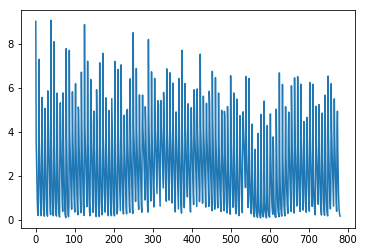

In [25]:
plt.plot(train_loss)

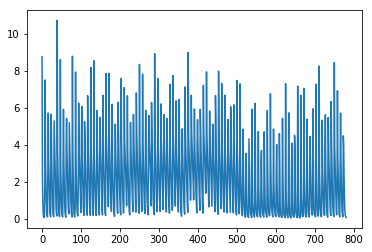

In [21]:
plt.plot(train_loss)

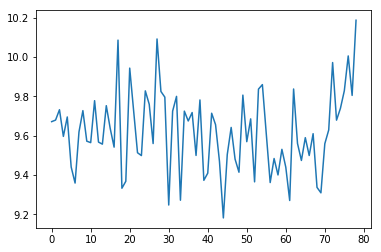

In [23]:
plt.plot(val_loss)

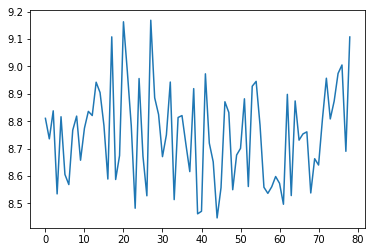

In [27]:
plt.plot(val_loss)

# Download + Preprocess Data

We end up with this file structure folder after first downloading everything:

development_kit
 * README
 * ...

data
 * labels
    * categories.txt
    * object_categories.txt
    * train.txt
    * val.txt
 * images
     * train
         * a
             * abbey
             * airport_terminal
             * ...
         * b
         * ...
     * val
     * test
 * objects
     * train
         * a
             * abbey
             * airport_terminal
             * ...
         * b
         * ...
     * val

The train images are stored in directories that correspond to their scene labels. All of the val and test images are stored directly in their directory. The labels for the val images (and for the test ones, for easier access) are in `development_kit/val.txt` and `/train.txt`.

All of the images are .jpg files. The images have been resized to 128x128 to make the challenge easier (computationally; it may be harder in terms of achieving the same accuracy).

The object notations are a special file that tells you the name of the image to which they correspond, where that image is (which folder), and then have bounding polygons (as a series of points) for the objects in the image, with classes for the objects. There are 3502 train images with object annotations and 371 validation images.

**Read the README to get a better idea of the data before continuing!**

## Download

In [4]:
%%bash
wget -q http://6.869.csail.mit.edu/fa17/miniplaces/development_kit.tar.gz
tar -xzf development_kit.tar.gz
rm development_kit.tar.gz

mkdir -p data/labels
mv development_kit/data/* data/labels
rm -r development_kit/data

cd data
wget -q http://6.869.csail.mit.edu/fa17/miniplaces/data.tar.gz
tar -xzf data.tar.gz
rm data.tar.gz

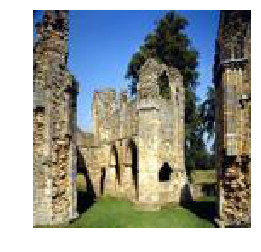

In [5]:
img = plt.imread('data/images/train/a/abbey/00000001.jpg')
plt.imshow(img)
plt.axis('off');

## Preprocess
* Put all train/val/test images in their own array for easy loading (the dataset is small enough that we can load all of them at once)

In [6]:
def save_imgs_together(split, convert_to_float=False, image_path='data/images', labels_path='data/labels/'):
    """
    Reads in all of the images from this split and saves them into a single numpy array.
    This should make the training easier and more efficient.
    :param split: one of train, val, or test; which split of the data to process
                  if split isn't test, the labels will also be saved into a numpy array
    :param convert_to_float: if true, the image array is divided by 255 to conver the data to floats in [0, 1]
    :param image_path: path to the first-level image directories (e.g. a, b, ...)
    :param labels_path: path to the labels data (e.g. train.txt, val.txt)
    """

    img_fnames = ! find $image_path/$split -name *.jpg | sort
    imgs = [plt.imread(img_fname) for img_fname in img_fnames]

    imgs = np.array(imgs)

    if convert_to_float:
        imgs = imgs / 255

    np.save('{}/{}.npy'.format(image_path, split), imgs)

    if split != 'test':  # no labels for test
        labels = pd.read_csv('{}/{}.txt'.format(labels_path, split), sep=' ', header=None, usecols=[1]).iloc[:, 0].values

        assert len(labels) == len(imgs)

        np.save('{}/{}_labels.npy'.format(image_path, split), labels.astype(np.int32))

In [7]:
for split in ['train', 'val', 'test']:
    save_imgs_together(split)

# Models

## ~Inception v4

In [8]:
tf.layers.separable_conv2d

<function tensorflow.python.layers.convolutional.separable_conv2d>

In [4]:
bn = False
layers = [
    # Image initial size 128 * 128
    ConvLayer(96, 11, 4, batch_norm=bn), # image size reduces to 32 * 32
    MaxPoolLayer(3, 2), # image size reduces to 16 * 16
    ConvLayer(256, 5, batch_norm=bn),
    MaxPoolLayer(3, 2), # image size reduces to 8 * 8
    ConvLayer(384, 3, batch_norm=bn),
    ConvLayer(384, 3, batch_norm=bn),
    ConvLayer(256, 3, batch_norm=bn),
    MaxPoolLayer(3, 2), # image size reduces to 4 * 4
    FlattenLayer(),
    DropoutLayer(0.5),
    DenseLayer(4096, batch_norm=bn),
    DropoutLayer(0.5),
    DenseLayer(4096, batch_norm=bn)
]

cnn = CNN(layers, n_classes=n_classes, record=False)

cnn.train(train_inputs[:1000], train_labels[:1000], val_inputs[:1000], val_labels[:1000], verbose=2, n_epochs=20,) # max_patience=20) # verbose 0 doesn't print anything, 2 progress bar in notebook, 1 terminal progress bar
# cnn.train(train_inputs, train_labels, val_inputs, val_labels, verbose=2, n_epochs=1) # verbose 0 doesn't print anything, 2 progress bar in notebook, 1 terminal progress bar

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

0/|/Epoch 1. Train Loss: 142.602. Dev loss: 30482074.000. Runtime 0.06.:   0%|| 0/20 [00:03<?, ?epoch/s]

A Jupyter Widget

A Jupyter Widget

1/|/Epoch 2. Train Loss: 0.000. Dev loss: 69558192.000. Runtime 0.08.:   5%|| 1/20 [00:04<01:31,  4.82s/epoch]

A Jupyter Widget

A Jupyter Widget

2/|/Epoch 3. Train Loss: 0.000. Dev loss: 82821280.000. Runtime 0.10.:  10%|| 2/20 [00:06<00:54,  3.05s/epoch]

A Jupyter Widget

A Jupyter Widget

3/|/Epoch 4. Train Loss: 0.000. Dev loss: 85998384.000. Runtime 0.12.:  15%|| 3/20 [00:07<00:41,  2.45s/epoch]

A Jupyter Widget

A Jupyter Widget

4/|/Epoch 5. Train Loss: 0.000. Dev loss: 86682880.000. Runtime 0.14.:  20%|| 4/20 [00:08<00:34,  2.16s/epoch]

A Jupyter Widget

A Jupyter Widget

{'acc_default': 0.011,
 'dev_loss': 30482074.0,
 'train_complete': False,
 'train_loss': 142.60155,
 'train_time': 0.05919735034306844}

In [10]:
cnn.score(val_inputs, val_labels)

TypeError: exceptions must derive from BaseException

In [ ]:
cnn = CNN(run_num=52)

In [ ]:
cnn.score(val_inputs, val_labels)

In [ ]:
# cnn.score(val_inputs, val_labels)

In [ ]:
preds = cnn.predict_proba(test_inputs)
output_file(preds)

In [ ]:
prelu()

## VGG

In [ ]:
cnn = PretrainedCNN(n_classes=n_classes, dense_nodes=(1024, 1024), batch_size=64, config=config, cnn_module='vgg16',
                   pretrained_weights=False)
cnn.train(train_inputs, train_labels, val_inputs, val_labels, in_notebook=True)

In [ ]:
# cnn = PretrainedCNN(run_num=20)

In [ ]:
cnn.score(val_inputs, val_labels)

In [ ]:
preds = cnn.predict_proba(val_inputs)
output_file(preds)

# Model Comparison

Adding batch norm: [0.23039998, 0.5126999]

Submitted Models

| Model | Acc@1 | Acc@5 | VAcc@1 | VAcc@5 | Notes | Run # |
|-----|
|  | .2429 | .4776 | 0.2509 | 0.5397 | | ??50-ish |
| | .2691 | .5224 | 0.2900 | 0.5844 | batch norm and l2=.001 | 58 |

In [ ]:
log = pd.read_hdf('models/log.h5', key='default').sort_values('dev_loss')
log.head()